#Procesamiento de imágenes satelitales meteorológicas con Python 2022.
### Sergio Masuelli
##Practico 4.

Objetivos: 
  
  1. Hacer y analizar dispersogramas.
  
  2. Aplicar índices
  
  3. Realizar transectas.

  4. Entender los conceptos de submuestreo y sobremuestreo. Aplicar la técnica de *Principal Component Analysis* (PCA) para la fusión de imágenes.
  
  5. Filtros de bordes y corregistro de imágenes.  

  6. Filtrado espacial de ruidos y realce de bordes,

## Preparación:



### Librerías y definición de funciones

En la siguiente celda se definen funciones especiales a usar en el práctico

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy import interpolate
#from scipy.ndimage.filters import uniform_filter
#from scipy.ndimage.measurements import variance
from scipy import signal
import math

from PIL import Image
# La siguiente línea configura al paquete Image para que pueda cargar imágenes
# muy grandes sin errores
Image.MAX_IMAGE_PIXELS = None
# Paquete para invocar al garbage collector
import gc
import os


# Función para calcular el PCA de una imagen de entrada
def pca(X):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].
    eigen_vals : numpy.array
        Array con los eigen values. 
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca, eigen_vals, eigen_vecs


def getCalibratedData(imageName, mtlFile):
    '''
    Levanta una imagen de Landsat 8 y el archivo de metadatos,
    devuelve una imagen calibrada a reflectancia.

    Parámetros
    ----------
    imageName : str
        Ruta y nombre de la imagen TIF a levantar.
    mtlFile : str
        Ruta y nombre del archivo de metadatos.

    Retornos
    --------
    img_ref : numpy.array
      Imagen calibrada a reflectancia
    '''
        
    # Del nombre de la imagen extraemos el número de banda
    bandNumber = imageName.split('_')[1].split('.TIF')[0].split('B')[1]
    # Leemos el archivo de metadatos
    with open(mtlFile, 'r') as f:
        metadata = f.readlines()
    # Extraemos los parámetros de calibración
    for line in metadata:
        # Extraemos el factor de multiplicación
        if line.find('REFLECTANCE_MULT_BAND_' + bandNumber) >= 0:
            REFLECTANCE_MULT_BAND = float(line.split('=')[1])
        # Extraemos el factor aditivo
        if line.find('REFLECTANCE_ADD_BAND_' + bandNumber) >= 0:
            REFLECTANCE_ADD_BAND = float(line.split('=')[1])
        # Extraemos el ángulo de elevación solar
        if line.find('SUN_ELEVATION') >= 0:
            SUN_ELEVATION = float(line.split('=')[1])
    # Leemos la imagen
    img = plt.imread(imageName)
    # Calibramos a reflectancia
    img_ref = (REFLECTANCE_MULT_BAND * img + REFLECTANCE_ADD_BAND) / np.sin(SUN_ELEVATION * np.pi/180)
    return img_ref


def muestreo(x, y, z, esc=1, kind='cubic'):
    '''
    Realiza un submuestreo o sobremuestreo según el parámetro 
    de entrada esc.
    
    Parámetros
    ----------
    x : numpy.array
        Array de coordenadas en x.
    y : numpy.array
        Array de coordenadas en y.
    z : numpy.array
        Array correspondiente a la imagen que se quiere sub
        o sobre muestrear.
    esc : int
        Indica si se submuestrea o sobremuestrea. Por ejemplo,
        esc=2 realiza un sobremuestreo al doble de tamaño. esc=0.5
        realiza un submuestreo a la mitad.
    kind : str
        Tipo de interpolación utilizada. Ver opciones en scipy.interpolate.interp2d().
        
    Retornos
    --------
    xnew : numpy.array
        Array de nuevas coordenadas en x.
    ynew : numpy.array
        Array de nuevas coordenadas en y.
    f(xnew, ynew) : numpy.array
        Array que contiene la nueva imagen sub o sobre muestreada.
    '''
    f = interpolate.interp2d(x, y, z, kind='cubic')
    xnew = np.arange(x[0], x[-1]+1, (x[1]-x[0])/esc) # válido sólo para escala 2:1
    ynew = np.arange(y[0], y[-1]+1, (y[1]-y[0])/esc) # válido sólo para escala 2:1
    return xnew, ynew, f(xnew, ynew)

### Importación de datos:

Las imágenes de Landsat 8 que vamos a utilizar en este notebook se encuentran en una carpeta de Google Drive a la cual se accede mediante el siguiente link:

https://drive.google.com/drive/folders/1Ez7tD_RMZZA5I0WZ9dtwWmyJbvyNtStO?usp=sharing

Al hacer click en el link anterior (teniendo su cuenta de Google logueada), la carpeta LO82290822015256COA00 será agregada a la sección "Compartido conmigo" de su Drive personal. Hacer click entonces sobre la carpeta, presionar shift + z, seleccionar Mi unidad (notar que ya aparece seleccionada en color verde) y presionar el botón Añadir. Una vez hecho lo anterior, debería ver la carpeta LO82290822015256COA00 en su unidad principal de Drive

Luego monte su Drive personal

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/Compartido conmigo/SATEC_alumnos/LO82290822015256COA00/')
dir_img = 'C:/Users/marti/Desktop/Procesamiento Imagenes Satelitales 2022/guia4/' #modificar esta linea
os.chdir(dir_img)

Verifique que accede al directorio "/content/drive/MyDrive/SATEC_alumnos/LO82290822015256COA00/" y debería ver los siguientes archivos:

```
LO82290822015256COA00_B1.TIF
LO82290822015256COA00_B2.TIF
LO82290822015256COA00_B3.TIF
LO82290822015256COA00_B4.TIF
LO82290822015256COA00_B5.TIF
LO82290822015256COA00_B6.TIF
LO82290822015256COA00_B7.TIF
LO82290822015256COA00_B8.TIF
LO82290822015256COA00_B9.TIF
LO82290822015256COA00_BQA.TIF
LO82290822015256COA00_MTL.txt
LO82290822015256COA00.jpg
```
*Notas: *

1. *El archivo **.txt** contiene los metadatos.*

2. *L8 tiene 2 bandas extra respecto de L5: una más en el azul (1) y otra pancromática (9). En consecuencia respecto de L5 los nombres de las bandas se hallan desplazados en 1, i.e. la banda 2 de L8 corresponde a la banda 1 de L5.*

In [4]:
# dir_imag = "/content/drive/MyDrive/LO82290822015256COA00/"
os.listdir(dir_img) #Este comando lista el contenido del directorio
mtlFile = dir_img + 'LO82290822015256COA00_MTL.txt'

Carga de las imágenes

In [5]:
# Inspeccionar el archivo LO82290822015256COA00_MTL.txt y buscar las líneas llamadas
# REFLECTIVE_LINES y REFLECTIVE_SAMPLES, las cuales contienen el número de filas
# y columnas de las bandas 1 a 7

rlines = 7761
rsamples = 7691
 
# Se inicializa una matriz que contendrá las imágenes leídas desde los archivos TIF
l8bands = np.zeros((rlines, rsamples, 7))

# Se realiza la lectura de las imágenes

for i in range(7):
    print('Cargando banda %d'%(i+1))
    l8bands[:, :, i] = getCalibratedData(dir_img + 'LO82290822015256COA00_B{:d}.TIF'.format(i+1), mtlFile)

Cargando banda 1
Cargando banda 2
Cargando banda 3
Cargando banda 4
Cargando banda 5
Cargando banda 6
Cargando banda 7


Seleccionar el área de interés. Hacer un recorte que abarque las ciudades de Córdoba y Carlos Paz y aplicar un realce al 2% a cada banda. Luego borrar la información original no necesaria

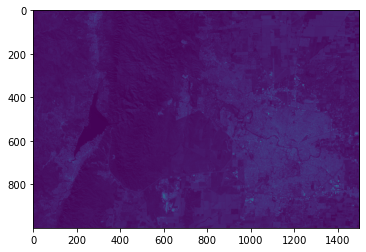

In [6]:
fini = 2000
finf = 3000
cini = 2500
cfin = 4000

plt.imshow(l8bands[fini:finf, cini:cfin, 1]/l8bands[..., [3, 2, 1]].flatten().max())

In [7]:
l8bands_rec = l8bands[fini:finf, cini:cfin, :]
# recorte = l8bands[2000:3000,2500:4500,:]
# Borramos el arreglo que contiene las imágenes sin recortar
del l8bands
# # Invocamos al Garbage Collector para asegurarnos que la memoria haya sido liberada
gc.collect()

0

In [8]:
def realce(vec, p):
  aux = np.sort(vec.flatten())
  imin = int(len(aux) * p / 100)
  imax = int(len(aux) * (100 - p) / 100)
  vmin = float(aux[imin])
  vmax = float(aux[imax])
  rimag = (vec - vmin) / (vmax - vmin)
  rimag[rimag < 0] = 0
  rimag[rimag > 1] = 1
  return rimag

In [9]:
l8 = np.zeros_like(l8bands_rec)
for i in range(7):
  l8[:, :, i] = realce(l8bands_rec[:, :, i], 2)

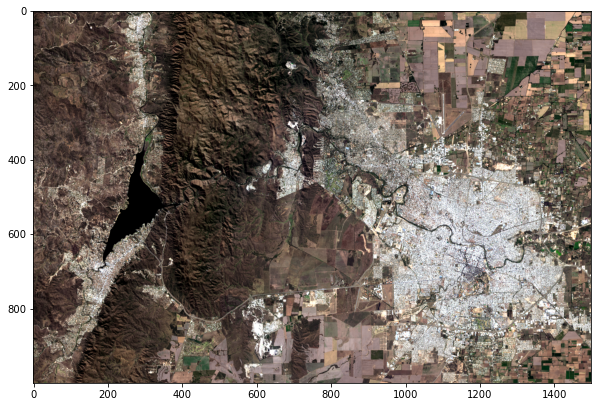

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(l8[:, :, [3, 2, 1]])

In [10]:
# R_rec = np.zeros(recorte.shape)
# for k in range(7):
#   R_rec[:, : ,k] = realce(recorte[:, : ,k], 2)

In [85]:
# lfil = 1000
# lcol = 2000
# fil0 = 2000 #coordenada de la primera fila 
# col0 = 2500 #coordenada de la primera columna

# l8bands_rec = R_rec
# # [fil0: fil0 + lfil, col0: col0 + lcol, :]


# # Borramos el arreglo que contiene las imágenes sin recortar
# del l8bands
# # Invocamos al Garbage Collector para asegurarnos que la memoria haya sido liberada
# gc.collect()

16

## Procesos



### 1. Dispersograma

Crear dispersogramas de algunas combinaciones de bandas. Para ello, utilizar la función **matplotlib.pyplot.hist2d**.

a. Obtener los dispersogramas de las bandas 1 y 2; 5 y 4; 6 y 3

b. Usar los dispersogramas para identificar los valores correspondientes al Lago San Roque y desplegar la imagen con este lago pintado  de azul saturado

Text(0, 0.5, 'banda 3')

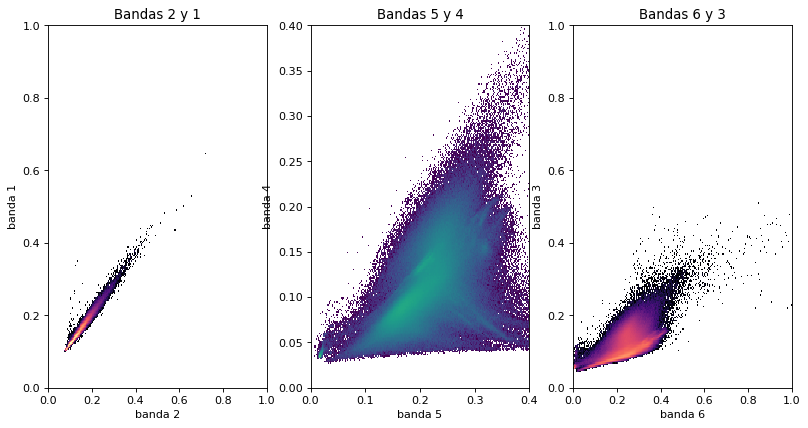

In [11]:
import matplotlib
# Creamos un objeto para normalizar las gráficas de forma logarítmica
norm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(12, 6), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(1, 3, 1)

plt.hist2d(l8bands_rec[:, :, 1].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           l8bands_rec[:, :, 0].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
plt.title('Bandas 2 y 1')
plt.xlabel('banda 2')
plt.ylabel('banda 1')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(1, 3, 2)

plt.hist2d(l8bands_rec[:, :, 4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           l8bands_rec[:, :, 3].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           range=[[0, .4], [0, .4]],                              # Limitamos el rango de visualización
           norm=norm)                                              # Aplicamos la norma logarítmica

# plt.hist2d(l8[:, :, 3].reshape(l8bands_rec[:, :, 3].size), # Coordenadas del eje x (debe ser un vector undimensional)
#           l8[:, :, 4].reshape(l8bands_rec[:, :, 4].size), # Coordenadas del eje y (debe ser un vector undimensional)
#           bins=256,                                                # Cantidad de bines para la gráfica
#           range=[[0, .4], [0, .4]],                              # Limitamos el rango de visualización
#           norm=norm)                                              # Aplicamos la norma logarítmica
plt.title('Bandas 5 y 4')
plt.xlabel('banda 5')
plt.ylabel('banda 4')


# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(1, 3, 3)

plt.hist2d(l8bands_rec[:, :, 5].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           l8bands_rec[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
plt.title('Bandas 6 y 3')
plt.xlabel('banda 6')
plt.ylabel('banda 3')

In [41]:
# # Creamos un objeto para normalizar las gráficas de forma logarítmica
# norm = matplotlib.colors.LogNorm()

# # Creamos la figura
# plt.figure(figsize=(6, 6), dpi=80)

# # Graficamos el dispersograma de las bandas 1 y 2
# plt.hist2d(R_rec[:, :, 1].reshape(R_rec[:, :, 1].size), # Coordenadas del eje x (debe ser un vector undimensional)
#            R_rec[:, :, 0].reshape(R_rec[:, :, 0].size), # Coordenadas del eje y (debe ser un vector undimensional)
#            bins=256,                                                # Cantidad de bines para la gráfica
#            range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
#            norm=norm)                                               # Aplicamos la norma logarítmica
# plt.title('Bandas 1 y 2')
# plt.xlabel('banda 2')
# plt.ylabel('banda 1')


In [74]:
# plt.hist2d(R_rec[:, :, 4].reshape(R_rec[:, :, 4].size), # Coordenadas del eje x (debe ser un vector undimensional)
#            R_rec[:, :, 3].reshape(R_rec[:, :, 3].size), # Coordenadas del eje y (debe ser un vector undimensional)
#            bins=256,                                                # Cantidad de bines para la gráfica
#            range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
#            norm=norm)                                               # Aplicamos la norma logarítmica
# plt.title('Bandas 5 y 4')
# plt.xlabel('banda 5')
# plt.ylabel('banda 4')

In [44]:
# plt.hist2d(R_rec[:, :, 5].reshape(R_rec[:, :, 5].size), # Coordenadas del eje x (debe ser un vector undimensional)
#            R_rec[:, :, 2].reshape(R_rec[:, :, 2].size), # Coordenadas del eje y (debe ser un vector undimensional)
#            bins=256,                                                # Cantidad de bines para la gráfica
#            range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
#            norm=norm)                                               # Aplicamos la norma logarítmica
# plt.title('Bandas 6 y 3')
# plt.xlabel('banda 6')
# plt.ylabel('banda 3')

In [ ]:
# Pintado del lago San Roque

* El profe dice que no hay correlacion en los demas, solo la primera tiene da lo mismo usar la 0 la 1. 
* Arranca de 0 las bandas por eso le resta una. 

## 2. Generación de índices.

a. Generar una función que permita obtener índices normalizados para 2 bandas cualesquiera.

b. Obtener los índices normalizados para vegetación y para agua. Comparar estos resultados con los dispersogramas correspondientes y analizar su relación con la imagen.

c. Con los índices anteriores obtener un clasificador similar al realizado en el Práctico 3 y compare los resultados.



Text(0, 0.5, 'banda 4')

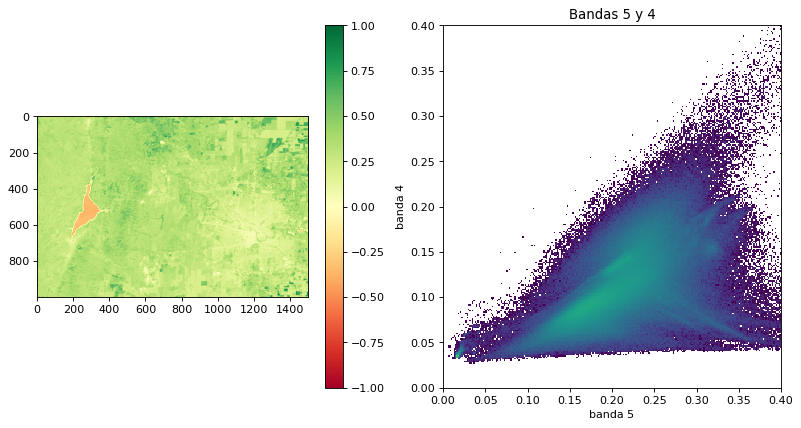

In [12]:
def indice(b1, b2):
  ind = np.zeros_like(b1)
  iaux = b2 + b1 > 0
  ind[iaux] = (b2[iaux] -b1[iaux]) / (b2[iaux] + b1[iaux])
  return ind

plt.figure(figsize=(12, 6), dpi=80)

plt.subplot(1, 2, 1)
# (Banda 5 – Banda 4)/(Banda 5 + Banda 4)
ndvi = indice(l8bands_rec[:, :, 3], l8bands_rec[:, :, 4])

plt.imshow(ndvi, cmap='RdYlGn', vmin=-1.0, vmax=1.0)
plt.colorbar()

# Comparar con dispersograma 4 y 5
plt.subplot(1, 2, 2)

plt.hist2d(l8bands_rec[:, :, 4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           l8bands_rec[:, :, 3].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           range=[[0, .4], [0, .4]],                              # Limitamos el rango de visualización
           norm=norm)                                              # Aplicamos la norma logarítmica

# plt.hist2d(l8[:, :, 3].reshape(l8bands_rec[:, :, 3].size), # Coordenadas del eje x (debe ser un vector undimensional)
#           l8[:, :, 4].reshape(l8bands_rec[:, :, 4].size), # Coordenadas del eje y (debe ser un vector undimensional)
#           bins=256,                                                # Cantidad de bines para la gráfica
#           range=[[0, .4], [0, .4]],                              # Limitamos el rango de visualización
#           norm=norm)                                              # Aplicamos la norma logarítmica
plt.title('Bandas 5 y 4')
plt.xlabel('banda 5')
plt.ylabel('banda 4')


Podemos obervar una tendencia hacia la relacion lineal con mayor densidad de puntos en los sitios donde hay mayor porcentaje de vegetacion presente. 

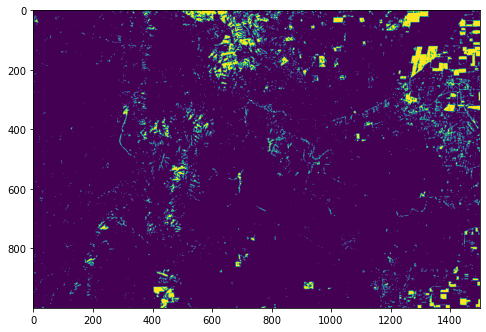

In [13]:
# Clasificador:

Clasif = np.copy(ndvi[:,:]) #Imagen final temática

# NDVI
a_umbral1 = np.array([0.5])
a_umbral2 = np.array([1])

# #filtro (árbol de desición implementado mediante productos de filtros)
for k in [0]:
  i_ndvi = (ndvi[:,:] > a_umbral1[k]) * (ndvi[:, :] < a_umbral2[k])

Clasif[i_ndvi==True] = 1
Clasif[i_ndvi==False] = 0

plt.figure(figsize = (8,8))
plt.imshow(Clasif)

Text(0, 0.5, 'banda 5')

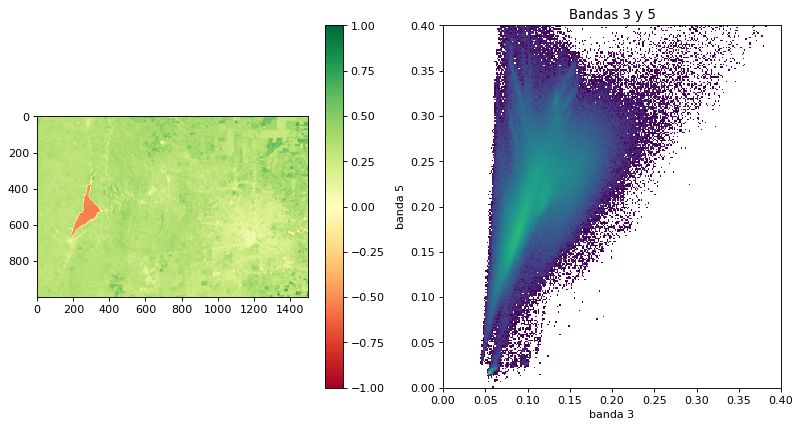

In [13]:
plt.figure(figsize=(12, 6), dpi=80)

plt.subplot(1, 2, 1)

# NDWI = (Band 3 – Band 5)/(Band 3 + Band 5)
ndwi = indice(l8bands_rec[:, :, 2], l8bands_rec[:, :, 4])

plt.imshow(ndwi, cmap='RdYlGn', vmin=-1.0, vmax=1.0)
plt.colorbar()

# Comparar con dispersograma 3 y 5
plt.subplot(1, 2, 2)

plt.hist2d(l8bands_rec[:, :, 2].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           l8bands_rec[:, :, 4].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           range=[[0, .4], [0, .4]],                              # Limitamos el rango de visualización
           norm=norm)                                              # Aplicamos la norma logarítmica
plt.title('Bandas 3 y 5')
plt.xlabel('banda 3')
plt.ylabel('banda 5')

Podemos obervar una tendencia hacia la relacion lineal con mayor densidad de puntos en los sitios donde hay agua presente. 

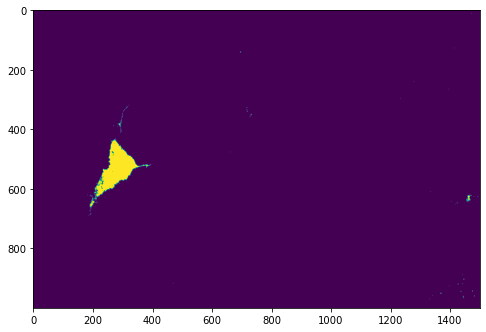

In [14]:
# Clasificador:
Clasif = np.copy(ndwi[:,:]) #Imagen final temática

# NDVI
a_umbral1 = np.array([-1])
a_umbral2 = np.array([-0.5])

# #filtro (árbol de desición implementado mediante productos de filtros)
for k in [0]:
  i_ndwi = (ndwi[:,:] > a_umbral1[k]) * (ndwi[:, :] < a_umbral2[k])

Clasif[i_ndwi==True] = 1
Clasif[i_ndwi==False] = 0

plt.figure(figsize = (8,8))
plt.imshow(Clasif)

## 3. Transectas

a. Elija dos puntos, un bien dentro del lago y otro bien en la tierra.

b. Haga una función que determine los puntos que pertencen a dicha transecta.

c. Grafique los valores para las distintas bandas vs esos puntos. ¿Puede identificar la lı́nea de costa?

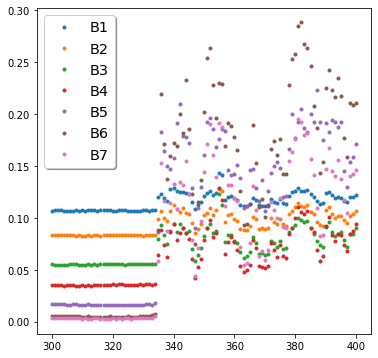

In [15]:
#a) Marcamos los dos puntos uno dentro y otro fuera del agua.
p1 = np.array([500, 300]) # dentro del lago
p2 = np.array([600, 400]) # fuera del lago

#b) Con esta funcion defino el segmento en las x entre los dos puntos

def segmento(p1, p2):
  x = np.arange(p1[1], p2[1]+1)
  y = np.rint(p1[0] + (x - p1[1]) * (p2[0] - p1[0]) / (p2[1] - p1[1]))
  return x, y.astype('int')

x, y = segmento(p1, p2) 

#c)

plt.figure(figsize= [6, 6])
for k in range(7):
  plt.plot(x, l8bands_rec[y, x, k], '.', label = 'B' + str(k + 1))

legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')


La linea de costa se encuentra a los 335 en x.

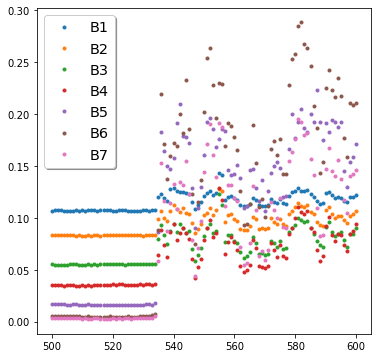

In [21]:
plt.figure(figsize= [6, 6])
for k in range(7):
  plt.plot(y, l8bands_rec[y, x, k], '.', label = 'B' + str(k + 1))

legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')

Y a los 535 en y aproximadamente. 

Sirve tambien para armar el arbol de desicion para clasificar entre terreno y agua. Me concentro en la banda que de homogenea en el agua, la banda uno da bien. 

## 4. Sobremuestreo y fusión de imágenes

La idea de este ejercicio es la de realizar un sobremuestreo de una imagen RGB (bandas 4, 3, 2) del Landsat mediante la aplicación de la técnica de PCA y la banda pancromática.

Realizar un recorte de la imagen RGB comenzando desde la esquina superior izquierda (coordenada [0, 0]) de 800x800 pixeles. Hacer lo mismo para la banda pancromática pero para un tamaño del recorte del doble que la anterior (1600x1600). Aplicar realce a las bandas y graficar

In [16]:
filas_rgb_rec = 800
columnas_rgb_rec = 800

RGBrec = np.zeros((filas_rgb_rec, columnas_rgb_rec, 3))
RGBrec[:, :, 0] = l8bands_rec[:filas_rgb_rec,:columnas_rgb_rec,3]
RGBrec[:, :, 1] = l8bands_rec[:filas_rgb_rec,:columnas_rgb_rec,2]
RGBrec[:, :, 2] = l8bands_rec[:filas_rgb_rec,:columnas_rgb_rec,1]

# Aplique un realce a x_pca_3d
RGBrec_realzada = np.zeros_like(RGBrec)
for i in range(3):
  RGBrec_realzada[:, :, i] = realce(RGBrec[:, :, i], 2)


PANCRO = getCalibratedData(dir_img + 'LO82290822015256COA00_B' + str(8) + '.TIF', mtlFile)

In [23]:
PANCROrec = PANCRO[2*fini:2*fini+2*filas_rgb_rec,2*cini:2*cini+2*columnas_rgb_rec]

Aplicar la transformación PCA a dicho recorte de manera de obtener sus componentes principales. Luego graficar dichas componentes realzadas.

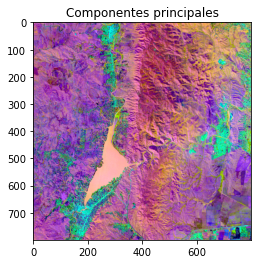

In [24]:
# Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

# Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
# NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
#       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
#       dimensiones adecuadas para aplicar la función.
# x_pca_3d = np.reshape(x_pca, [..., ..., ...])
x_pca_3d = np.reshape(x_pca, [filas_rgb_rec, columnas_rgb_rec, 3])

# Aplique un realce a x_pca_3d
x_pca_3d_realzada = np.zeros_like(x_pca_3d)
for i in range(3):
  x_pca_3d_realzada[:, :, i] = realce(x_pca_3d[:, :, i], 2)

plt.figure()
plt.imshow(x_pca_3d_realzada)
plt.title('Componentes principales')
plt.show()

Text(0.5, 1.0, 'Componentes principales')

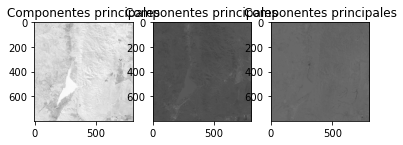

In [25]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(x_pca_3d[:,:,0],"gray")
plt.title('Componentes principales')

plt.subplot(1,3,2)
plt.imshow(x_pca_3d[:,:,1],"gray")
plt.title('Componentes principales')

plt.subplot(1,3,3)
plt.imshow(x_pca_3d[:,:,2],"gray")
plt.title('Componentes principales')

La matriz x_pca_3d contiene las componentes principales de la matriz RGBrec. En la primera banda se encuentra la componente principal 1 (CP1), en la segunda banda se encuentra la CP2 y en la tercera banda la CP3.

Hacer un remuestreo de la CP para llevarla a resolución de la PANCRO

Observe y compare CP1 contra PANCROrec, visualizando y realizando un scatterplot.




In [26]:
cp_interp = np.zeros((filas_rgb_rec * 2, columnas_rgb_rec * 2,3))

# Realizamos el sobremuestreo de las CP2 y CP3. Para ello pasamos como argumentos a la función 
# muestreo() los arrays de coordenadas y las correspondientes componentes.
# NOTA: note que la función devuelve los valores de coordenadas xy en los primeros 
#       dos retornos, pero dado que esas variables no se van a usar, se utiliza el
#       caracter _ para ignorarlos.
_, _, cp_interp[:, :, 0] = muestreo(np.arange(0, filas_rgb_rec), np.arange(0, columnas_rgb_rec), x_pca_3d[:, :, 0], esc=2)

_, _, cp_interp[:, :, 1] = muestreo(np.arange(0, filas_rgb_rec), np.arange(0, columnas_rgb_rec), x_pca_3d[:, :, 1], esc=2)

_, _, cp_interp[:, :, 2] = muestreo(np.arange(0, filas_rgb_rec), np.arange(0, columnas_rgb_rec), x_pca_3d[:, :, 2], esc=2)


Realizar un sobre muestreo a CP2 y CP3 llevarlas a la resolución de la pancromática. Luego cargar las CP correspondientes pero poniendo en lugar de la CP1 la PANCRO reescaleada. Analice la correlación entre estas dos uĺtimas bandas.

Nota: Observe las dimensiones, puede que necesite hacer un reshape

Analice la correlación entre la CP1 y la PANCRO mediante un scatterplot

Text(0, 0.5, 'PancroRec')

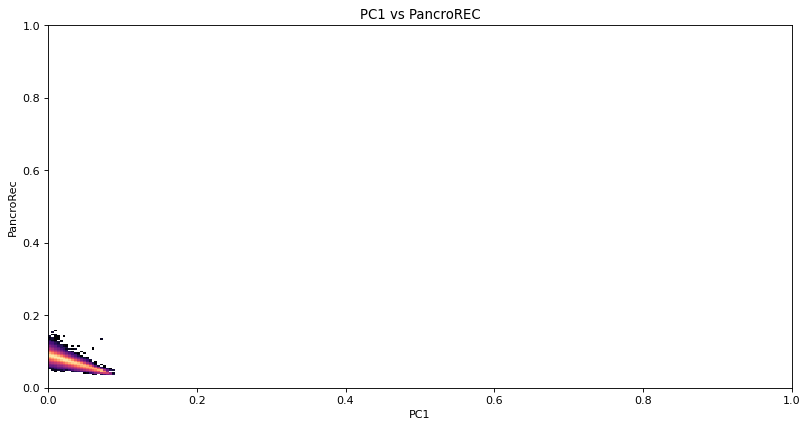

In [27]:
# Creamos la figura
plt.figure(figsize=(12, 6), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.hist2d(cp_interp[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           PANCROrec[:, :].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
plt.title('PC1 vs PancroREC')
plt.xlabel('PC1')
plt.ylabel('PancroRec')


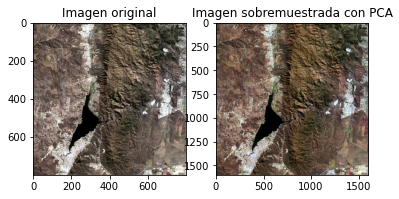

In [28]:
cp_interp[:, :, 0] = -PANCROrec

cp_reshape = cp_interp.reshape(4 * filas_rgb_rec * columnas_rgb_rec, 3)

# Analizar lo siguiente tranquilos:
# Pasamos de espacio pca a la imagen
IMG = np.matmul(eigen_vecs, cp_reshape.T).T + np.mean(RGBrec.reshape([filas_rgb_rec * columnas_rgb_rec, 3]), 0)

# Obtenemos nuevamente una imagen 3D para graficar
IMG_reshape = np.reshape(IMG, [2*filas_rgb_rec,2*columnas_rgb_rec,3]) # Completar!!!

# Realzamos la imagen para mejorar la visualización
IMG_real = np.zeros_like(IMG_reshape)
for i in range(3):
  IMG_real[:, :, i] = realce(IMG_reshape[:, :, i], 2)

# Graficamos la imagen original y la sobremuestreada
plt.figure()
plt.subplot(1,2,1)
plt.imshow(RGBrec_realzada)
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(IMG_real)
plt.title('Imagen sobremuestrada con PCA')
plt.show()

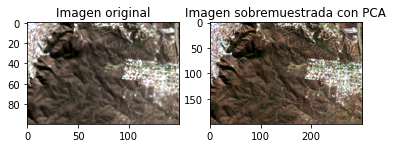

In [29]:
# Graficamos la imagen original y la sobremuestreada con zoom
plt.figure()
plt.subplot(1,2,1)
plt.imshow(RGBrec_realzada[700:850,200:350,:])
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(IMG_real[1400:1700,400:700,:])
plt.title('Imagen sobremuestrada con PCA')
plt.show()

Compare las imágenes anteriores y vea cómo se incrementó la resolución espacial. Juegue con el zoom para ver los detalles en ambas imágenes.

A pesar de tener distinta tonalidad se pueden apreciar mas detalles en la imagen sobremuestreada, estos detalles hacen referencia al tendido de calles que puede observarse con mayor claridad en el uso de suelo urbano de la imagen. 

### 5. Corregistro de imágenes

En esta parte del trabajo práctico vamos a trabajar nuevamente con las imágenes del Landsat 8 de la sección anterior para realizar un corregistro de bandas, pero las vamos a cargar a partir de los arrays de Numpy con extensión **.npy**.

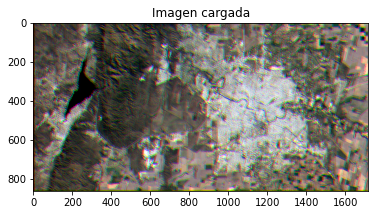

In [30]:
path = dir_img

# Cargamos los arrays
Rshift = np.load(path + 'Rshift.npy')
Gshift = np.load(path + 'Gshift.npy')
Bshift = np.load(path + 'Bshift.npy')

# Obtenemos sus dimensiones
filas, columnas = np.shape(Rshift)

# Creamos una imagen RGB realzada
RGBshift = np.zeros((filas, columnas, 3))
RGBshift[:, :, 0] = realce(Rshift,2)
RGBshift[:, :, 1] = realce(Gshift,2)
RGBshift[:, :, 2] = realce(Bshift,2)

# Graficamos
plt.figure()
plt.imshow(RGBshift)
plt.title('Imagen cargada')
plt.show()

<div class="alert alert-block alert-warning">
    <b>Pregunta:</b> ¿Qué tipo de defecto puede notar en la imagen?
    
Parece que las bandas se encuentran corridas y eso genera turbidez en la definicion de la imagen.
</div>

Vamos a realizar un recorte sobre la imagen anterior, de manera de enfocarnos en alguna zona que contenga bordes o interfaces que nos ayuden a corregistrar las bandas. Para ello, hacemos un recorte de la imagen anterior de 200x200 píxeles comenzando en la coordenada superior izquierda [600, 800] y graficamos.

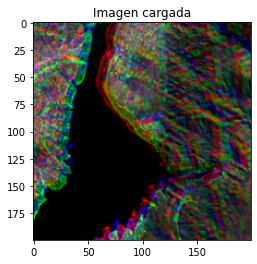

In [31]:
# Zoom
plt.figure()
plt.imshow(RGBshift[200:400,200:400,:])
plt.title('Imagen cargada')
plt.show()

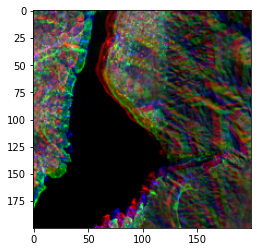

In [33]:
# Hacemos el recorte
RGBshift_rec = RGBshift[200:400,200:400]

# Graficamos
plt.figure()
plt.imshow(RGBshift_rec)
plt.show()

Para poder determinar de mejor manera el desplazamiento de las bandas, vamos a aplicar un filtro resaltabordes de Sobel para resaltar todos los bordes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


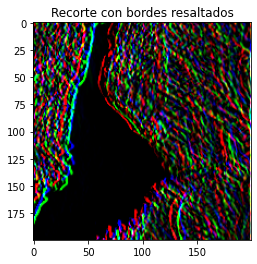

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


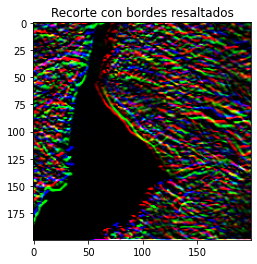

In [35]:
# Creamos los kernels de Sobel
sx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
# sy = np.array([[-1,-2,1],[0,0,0],[1,2,1]])
sy=sx.T

filt_x = np.zeros_like(RGBshift_rec)
filt_y = np.zeros_like(RGBshift_rec)

# filtro de sobel x aplicado a la imagen 0
filt_x[:, :, 0] = signal.convolve2d(RGBshift_rec[:, :, 0], sx, mode = 'same')
filt_x[:, :, 1] = signal.convolve2d(RGBshift_rec[:, :, 1], sx, mode = 'same')
filt_x[:, :, 2] = signal.convolve2d(RGBshift_rec[:, :, 2], sx, mode = 'same')

filt_y[:, :, 0] = signal.convolve2d(RGBshift_rec[:, :, 0], sy, mode = 'same')
filt_y[:, :, 1] = signal.convolve2d(RGBshift_rec[:, :, 1], sy, mode = 'same')
filt_y[:, :, 2] = signal.convolve2d(RGBshift_rec[:, :, 2], sy, mode = 'same')

plt.figure()
plt.imshow(filt_x)
plt.title('Recorte con bordes resaltados')
plt.show()

plt.figure()
plt.imshow(filt_y)
plt.title('Recorte con bordes resaltados')
plt.show()

Observe que la imagen anterior ahora tiene resaltados todos los bordes y se hace evidente el desplazamiento entre las bandas R, G y B.

Tomando la banda R como referencia, ahora debemos determinar cuál es el desplazamiento de las bandas G y B respecto a ésta. Para ello, vamos a aplicar una correlación 2D entre las bandas.

In [44]:
# Hacemos la correlación 2D entre el filtro R y el R
# Hacemos zoom
fila, fila_r= 80,120
cor_RR = signal.correlate2d(filt_x[fila:fila_r, fila:fila_r, 0], filt_x[fila:fila_r, fila:fila_r, 0], mode="same")

# Hacemos la correlación 2D enre el filtro R y el B
cor_RG = signal.correlate2d(filt_x[fila:fila_r, fila:fila_r, 0], filt_x[fila:fila_r, fila:fila_r, 1], mode="same")

# Hacemos la correlación 2D enre el filtro R y el G
cor_RB = signal.correlate2d(filt_x[fila:fila_r, fila:fila_r, 0], filt_x[fila:fila_r, fila:fila_r, 2], mode="same")

Graficamos las correlaciones y vemos que nos da.

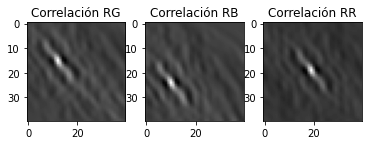

In [45]:
plt.figure()

plt.subplot(1,3,1)
plt.imshow(cor_RG, 'gray')
plt.title('Correlación RG')

plt.subplot(1,3,2)
plt.imshow(cor_RB, 'gray')
plt.title('Correlación RB')

plt.subplot(1,3,3)
plt.imshow(cor_RR, 'gray')
plt.title('Correlación RR')

plt.show()

<div class="alert alert-block alert-warning">
    <b>Preguntas:</b> ¿Qué representan las imágenes de las correlaciones anteriores? ¿Donde debería estar el punto máximo si las imágenes se encuentran corregistradas?
    
Las imagenes de correlacion muestran donde las imagenes se parecen mas. El punto en el centro muestra que las imagenes estan correladas, con el punto en el centro. El corrimiento lo mido restando los maximos en x e y respecto de la correlacion entre las bandas rojas. 
Podemos ver que la maxima correlacion entre la bandas rojas se enuentra en el centro, para las otras bandas vemos que es necesario desplazar para que coincidan las bandas. El punto deberia encontrarse en la misma posicion y como podemos apreciar este no lo esta. 
</div>

A partir de las matrices de correlación obtenidas, podemos determinar cual es el corrimiento de cada banda respecto de la banda R.

Lo hace con otra funcion que se llama unravel. numpy es lo mas bajo de nivel que me puedo encontrar en python para computo cientifico, es lo mas rapido.

In [47]:
lpix2 = cor_RR.shape[0]
# Esto es consecuencia de que lo pae a  algo de una sola dimension
dcG = cor_RG.argmax()%(lpix2)-cor_RR.argmax()%(lpix2)
dfG = cor_RG.argmax()//(lpix2)-cor_RR.argmax()//(lpix2)
# argmax tira la posicion del maximo. 
print('Corrimiento de G respecto de R filas= %d columnas= %d' %(dfG, dcG))

lpix2 = cor_RR.shape[0]
dcB = cor_RB.argmax()%(lpix2)-cor_RR.argmax()%(lpix2)
dfB = cor_RB.argmax()//(lpix2)-cor_RR.argmax()//(lpix2)

print('Corrimiento de B respecto de R filas= %d columnas= %d' %(dfB, dcB))

Corrimiento de G respecto de R filas= -4 columnas= -7
Corrimiento de B respecto de R filas= 5 columnas= -9


Desplazar las imágenes para corregistrarlas utilizando la función scipy.ndimage.shift().

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


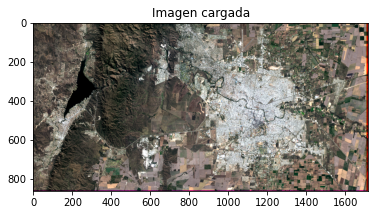

In [48]:
# Corregimos el desplazamiento usando ndimage.shift y graficamos

#Cargando la nueva matriz
RGB_good = np.copy(RGBshift)
RGB_good[:, : , 1] = ndimage.shift(RGB_good[:, : , 1], [dfG, dcG])
RGB_good[:, : , 2] = ndimage.shift(RGB_good[:, : , 2], [dfB, dcB])


# Graficamos la imagen y un zoom conveniente
plt.figure()
plt.imshow(RGB_good)
plt.title('Imagen cargada')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


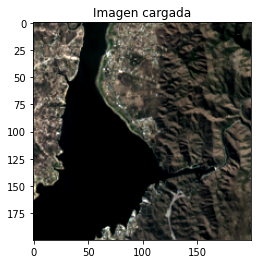

In [49]:
# Graficamos la imagen y un zoom conveniente
plt.figure()
plt.imshow(RGB_good[200:400,200:400,])
plt.title('Imagen cargada')
plt.show()

##6) Procesos para Filtrado de ruido y Realce de bordes:


1) Elija una de las bandas de la imagen LandsaTM 229-82, seleccione una región de 300x300 con paisajes variados alrededor del lago San Roque, recórtela y cárguela en un array de numpy.

2) Súmele un ruido uniforme de amplitud A y media 0,1.

3) Implemente un filtro como función que tenga como entradas la imagen y el kernel. El kernel debe ser una matriz de dimensión impar.

4) Genere distintos filtros de suavizado y resaltado.

5) Aplique el filtro de suavizado a la imagen y compare visualmente la imagen obtenida con respecto a la imagen original.

6) Utilice la función scipy.signal.correlate para realizar el mismo suavizado. Compare la imagen obtenida con la del punto anterior.

7) Aplique sucesivamente un filtro de resaltado y compare con la imagen original.

8) Idem punto anterior pero que el filtro pasa alto sea el de Sobel con a= b= 1.

9) Invierta el orden, es decir primero pase el filtro pasa alto y luego el pasabajo, compare con la imagen original.


1) Elija una de las bandas de la imagen Landsat 8 realzada, seleccione una región de 300x300 con paisajes variados alrededor del lago San Roque, recórtela y cárguela en un array de numpy.

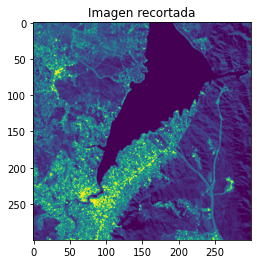

In [53]:
sr_rec=l8[450:750,100:400,0]

# Graficamos la imagen y un zoom conveniente
plt.figure()
plt.imshow(sr_rec)
plt.title('Imagen recortada')
plt.show()

2) Súmele un ruido uniforme entre valores de amplitud 0,1 y media 0.

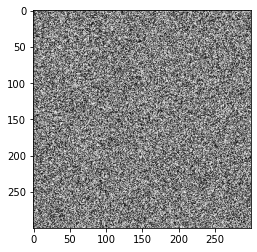

In [78]:
lpix =300
ruido = np.random.uniform(low=0, high=0.3, size = [lpix, lpix])

plt.imshow(ruido, cmap = 'gray')

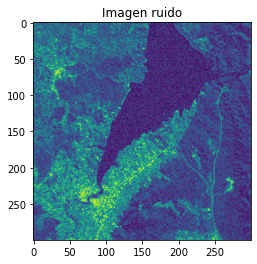

In [79]:
sr_ruido=sr_rec+ruido

# Graficamos la imagen y un zoom conveniente
plt.figure()
plt.imshow(sr_ruido)
plt.title('Imagen ruido')
plt.show()

3) Implemente un filtro como función que tenga como entradas la imagen y el kernel. El kernel debe ser una matriz de dimensión impar.

In [80]:
def filtro(img, kernel):
    conv = signal.convolve2d(img, kernel)
    return conv

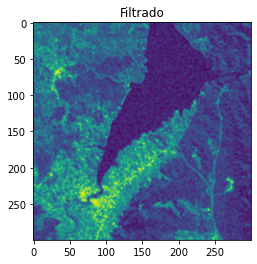

In [81]:
# Creamos los kernels de Sobel
kernel = np.array([[1/16,2/16,1/16],[2/16,4/16,2/16],[1/16,2/16,1/16]])

filt = np.zeros_like(sr_ruido)

# filtro de Sobel en x aplicado a la imagen 0
filt[:, :] = signal.convolve2d(sr_ruido[:, :], kernel, mode = 'same')

plt.figure()
plt.imshow(filt)
plt.title('Filtrado')
plt.show()

4) Genere distintos filtros de suavizado y resaltado.

In [82]:
kernel_suavisado = np.ones([3,3])/9
kernel_resaltado = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) 

In [83]:
img_suavizada=filtro(sr_ruido[:, :],kernel_suavisado)
img_resaltado=filtro(sr_ruido[:, :],kernel_resaltado)

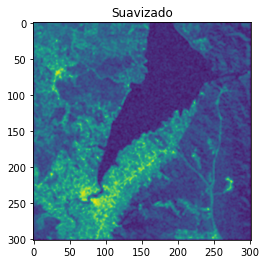

In [84]:
plt.figure()
plt.imshow(img_suavizada)
plt.title('Suavizado')
plt.show()

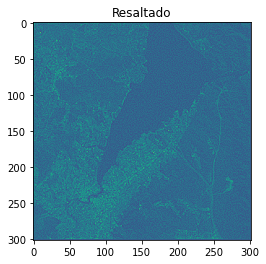

In [85]:
plt.figure()
plt.imshow(img_resaltado)
plt.title('Resaltado')
plt.show()

Se ve tan feo porque lo que esta resaltando en este caso es el ruido.

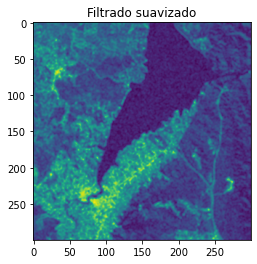

In [86]:
# Creamos los kernels de Sobel
kernel = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])

filt = np.zeros_like(sr_ruido)

# filtro de Sobel en x aplicado a la imagen 0
filt[:, :] = signal.convolve2d(sr_ruido[:, :], kernel, mode = 'same')

plt.figure()
plt.imshow(filt)
plt.title('Filtrado suavizado')
plt.show()

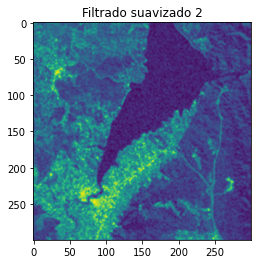

In [87]:
# Creamos los kernels de Sobel
kernel = np.array([[1/11,1/11,1/11],[1/11,3/11,1/11],[1/11,1/11,1/11]])

filt = np.zeros_like(sr_ruido)

# filtro de Sobel en x aplicado a la imagen 0
filt[:, :] = signal.convolve2d(sr_ruido[:, :], kernel, mode = 'same')

plt.figure()
plt.imshow(filt)
plt.title('Filtrado suavizado 2')
plt.show()

5) Aplique el filtro de suavizado a la imagen usando la función scipy.signal.correlate y compare visualmente la imagen obtenida con respecto a la imagen original.

In [59]:
corr = signal.correlate(sr_ruido, sr_rec, mode='same') 

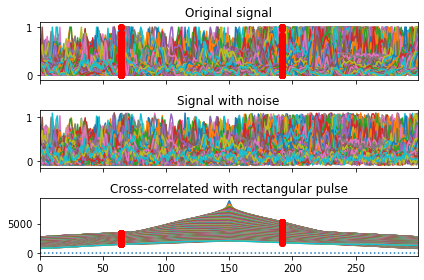

In [60]:
clock = np.arange(64, len(sr_rec), 128)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sr_rec)
ax_orig.plot(clock, sr_rec[clock], 'ro')
ax_orig.set_title('Original signal')
ax_noise.plot(sr_ruido)
ax_noise.set_title('Signal with noise')
ax_corr.plot(corr)
ax_corr.plot(clock, corr[clock], 'ro')
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated with rectangular pulse')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

6 ) Aplique sucesivamente un filtro de resaltado y compare con la imagen original.

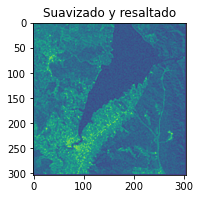

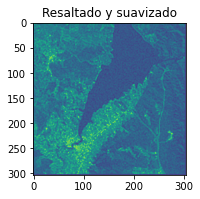

In [90]:
suav_res = filtro(img_suavizada,kernel_resaltado)
res_suav = filtro(img_resaltado,kernel_suavisado)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(suav_res)
plt.title('Suavizado y resaltado')
plt.show()

plt.subplot(1,2,2)
plt.imshow(res_suav)
plt.title('Resaltado y suavizado')
plt.show()


Quedan iguales.

In [91]:
kernel_suavisado @ kernel_resaltado

array([[-0.11111111,  0.33333333, -0.11111111],
       [-0.11111111,  0.33333333, -0.11111111],
       [-0.11111111,  0.33333333, -0.11111111]])

In [92]:
kernel_resaltado @ kernel_suavisado 

array([[-0.11111111, -0.11111111, -0.11111111],
       [ 0.33333333,  0.33333333,  0.33333333],
       [-0.11111111, -0.11111111, -0.11111111]])

Son lo mismo pero transpuesto por eso dan igual las imagenes.

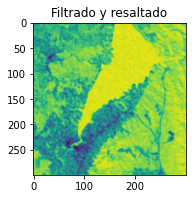

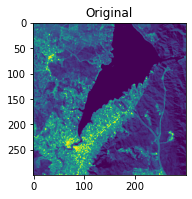

In [61]:
# Creamos los kernels de Sobel
kernel = np.array([[-1,-1,-1],[-1,-9,-1],[-1,-1,-1]])

res = np.zeros_like(filt)

# filtro de Sobel en x aplicado a la imagen 0
res[:, :] = signal.convolve2d(filt[:, :], kernel, mode = 'same')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(res)
plt.title('Filtrado y resaltado')
plt.show()

plt.subplot(1,2,2)
plt.imshow(sr_rec)
plt.title('Original')
plt.show()

7) Idem punto anterior pero que el filtro pasa alto sea el de Sobel.

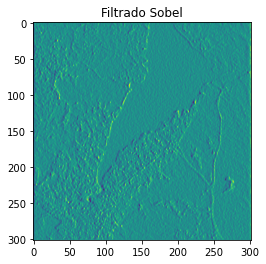

In [94]:
filtro_sobel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

img_sobel=filtro(sr_ruido[:, :],filtro_sobel)

plt.figure()
plt.imshow(img_sobel)
plt.title('Filtrado Sobel')
plt.show()

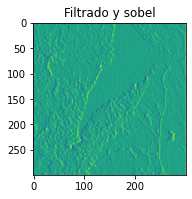

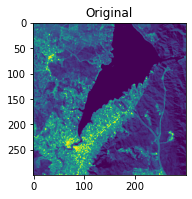

In [95]:
# Creamos los kernels de Sobel
kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

res = np.zeros_like(filt)

# filtro de Sobel en x aplicado a la imagen 0
res[:, :] = signal.convolve2d(filt[:, :], kernel, mode = 'same')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(res)
plt.title('Filtrado y sobel')
plt.show()

plt.subplot(1,2,2)
plt.imshow(sr_rec)
plt.title('Original')
plt.show()

8) Invierta el orden, es decir primero pase el filtro pasa alto y luego el pasabajo, compare con la imagen original.

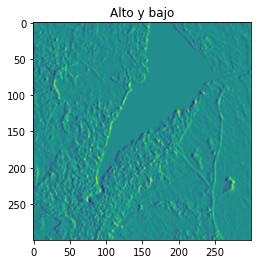

In [63]:
# Pasa alto
kernel_1 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

alto = np.zeros_like(filt)

# filtro de Sobel en x aplicado a la imagen 0
alto[:, :] = signal.convolve2d(sr_rec[:, :], kernel_1, mode = 'same')

# Pasa bajo
kernel_2 = np.array([[1/11,1/11,1/11],[1/11,3/11,1/11],[1/11,1/11,1/11]])

altoybajo = np.zeros_like(alto)

# filtro de Sobel en x aplicado a la imagen 0
altoybajo[:, :] = signal.convolve2d(alto[:, :], kernel_2, mode = 'same')

plt.figure()
plt.imshow(altoybajo)
plt.title('Alto y bajo')
plt.show()